# House Prices Advanced Regression Techniques
## Machine Learning with Pipelines, Stacking, and Voting Regressor


In this project, I will cover the cycle of machine learning project with pipeline, blending the estimators with stacking and voting.

The dataset if from Kaggle Competition - House Prices Advanced Regression Techniques. I choose to extract the dataset with Kaggle API and run on colab because Colab is more stable than Kaggle notebook. The public scores I got from these project are around 0.14, which is quite satisfactory on housing price prediction.



**The Lifecycle in a Data Science Projects:**

* Data Analysis
* Feature Engineering
* Feature Selection
* Feature Engineering
* Model Building



**Pipeline**

Piple is used to connect multiple estimators in sequence. It is useful to machine learning by combining a sequence of steps during data-processing such as feature engineering, data-scaling and regression in one chain. One of the major benefits of the pipeline is to help avoid data leakage when applying the trained model from cross-validation onto the test data.

Data leakage in an important topic in machine learning. When data scientists prepare the trained model, we have to separate the train and the test data separately. We attain the best accuracy in the trained model, but the model could fail when deploying into production. If some of the data in the test data is shared to the training set, or vice versa, the results from the leaked models would give us the deceptive and even unrealistically 'good' predictions. The test data is the simulation of the production in reality, thus the information in test dataset is not allowed to be known in the training data. Most data leakage is cuased by unintentional mistakes made during data preprocessing and feature engineering.

Data leakage is a common problem not only in data science competitions, but also in real production. The companies may lose much money on failed business plans due to the overly optismistic predictions with data leakage. We can avoid data leakage by cross-validation and pipeline. Sci-kit learn offer some useful techquies to tackle data leakager. We will walk through it in this model.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sklearn

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA

import time

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
import xgboost

%matplotlib inline

In [2]:
!pip install kaggle

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [4]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 65.1MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 16.4MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 61.4MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 26.5MB/s]


In [72]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [73]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# give the dimension of the training and test datasets
print('the matrix of training dataset:', train.shape)
print('the matrix of test dataset:', test.shape)

the matrix of training dataset: (1460, 81)
the matrix of test dataset: (1459, 80)


In [8]:
# save the 'Id' column
train_id = train['Id']
test_id = test['Id']

# drop the 'Id' colum because it's unnecessary for the modeling
train = train.drop('Id', axis = 1)
test = test.drop('Id', axis = 1)

## **1, Data Analysis**

Data analysis is the first and the most important step of machine learning project. All ML projects start with analysizing the dataset to summarise its main features. It gives us the rough idea of the types of features, the dimensions of the dataset, and other natures of the dataset. It helps us to decide the direction of the workflow of the project.

In [9]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [71]:
print('The dimension of the train dataset: ', train.shape)
print('The dimension of the test dataset: ', test.shape)

The dimension of the train dataset:  (1458, 80)
The dimension of the test dataset:  (1459, 68)


In [69]:
# let's take a look which features are categorical or numeric.
# and any missing data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1458 non-null   int64  
 1   MSZoning       1458 non-null   object 
 2   LotFrontage    1199 non-null   float64
 3   LotArea        1458 non-null   int64  
 4   Street         1458 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1458 non-null   object 
 7   LandContour    1458 non-null   object 
 8   Utilities      1458 non-null   object 
 9   LotConfig      1458 non-null   object 
 10  LandSlope      1458 non-null   object 
 11  Neighborhood   1458 non-null   object 
 12  Condition1     1458 non-null   object 
 13  Condition2     1458 non-null   object 
 14  BldgType       1458 non-null   object 
 15  HouseStyle     1458 non-null   object 
 16  OverallQual    1458 non-null   int64  
 17  OverallCond    1458 non-null   int64  
 18  YearBuil

**Visualization**

Visualization is the presentation of data in a pictorial or graphical format. It enables decision-makers to see analytics presented visually, so they can grasp difficult concepts or identify new patterns. This visualization of house prices is for the Kaggle dataset. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges predicting the final price of each home.

<Figure size 432x288 with 0 Axes>

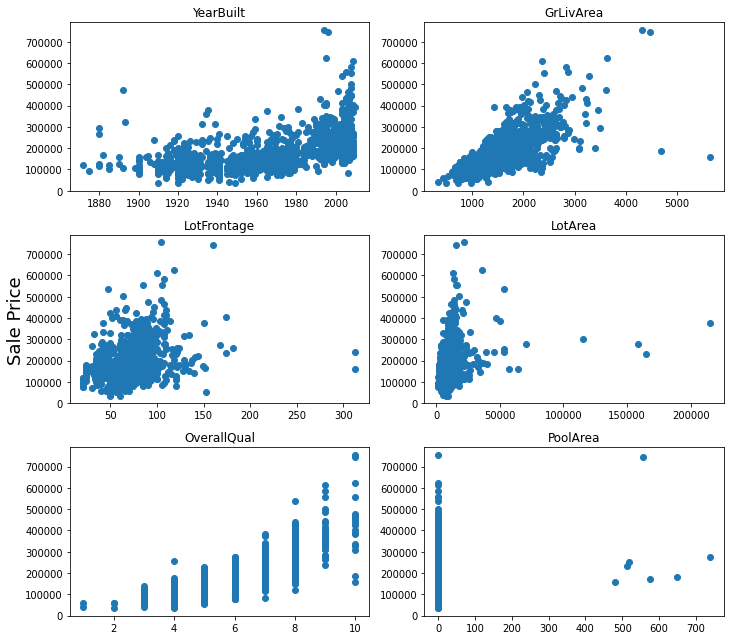

In [10]:
plt.figure(1)
f, axarr = plt.subplots(3, 2, figsize=(10, 9))
price = train.SalePrice.values
axarr[0, 0].scatter(train['YearBuilt'].values, price)
axarr[0, 0].set_title('YearBuilt')
axarr[0, 1].scatter(train.GrLivArea.values, price)
axarr[0, 1].set_title('GrLivArea')
axarr[1, 0].scatter(train.LotFrontage.values, price)
axarr[1, 0].set_title('LotFrontage')
axarr[1, 1].scatter(train['LotArea'].values, price)
axarr[1, 1].set_title('LotArea')
axarr[2, 0].scatter(train.OverallQual.values, price)
axarr[2, 0].set_title('OverallQual')
axarr[2, 1].scatter(train.PoolArea.values, price)
axarr[2, 1].set_title('PoolArea')
f.text(-0.01, 0.5, 'Sale Price', va='center', rotation='vertical', fontsize = 18)
plt.tight_layout()
plt.show()

## **2, Feature Engineer**

The Outliners:

Though all tree-based models are ideally robust to outliers. However, for some models such as linear models and SVR, the outliers will ruin the machine learning prediction.

Outliers can be easily detected by methods such as giving a control limit to any variable of 1.5 *IQR or by checking the underlying trend of the variable. for example, if you apply linear regression to any variable, the highest or the lowest value of the residuals may not follow the general trend and can be classified as outliers.

I will remove the samples from the lower right corners on the below plot because they are out of trend given that big amount of area.

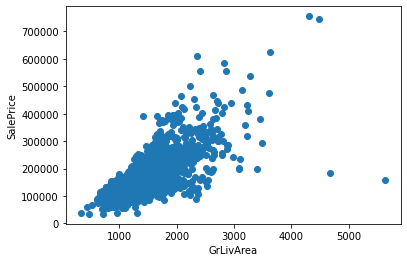

In [11]:
plt.scatter(train['GrLivArea'], train['SalePrice'], marker = 'o')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [12]:
# remove the outliers
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300000)].index)

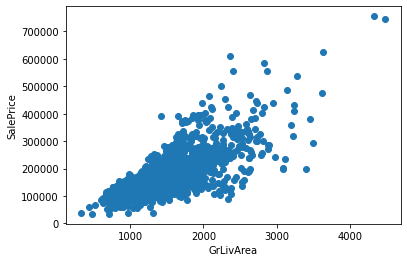

In [13]:
plt.scatter(train['GrLivArea'], train['SalePrice'], marker = 'o')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [14]:
# define the y-dependent and X-independent variables
X = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

## **3, Feature Selection**

We see the housing advertisement mostly provide with the information of the total number of bathrooms and the total size of the properties in square feet. Also, data scientists try to build a model with the principal of KISS, 'keep it simple, stupid. I want to keep as fewest features as possible. So I create two new columns of 'Total_Bathrooms' and 'TotalSF' by adding all bathrooms and square feet respectively.

In [15]:
X['Total_Bathrooms'] = X['FullBath'] + 0.5 * X['HalfBath'] + X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']
test['Total_Bathrooms'] = test['FullBath'] + 0.5 * test['HalfBath'] + test['BsmtFullBath'] + 0.5 * test['BsmtHalfBath']

In [16]:
X['TotalSF'] = X['1stFlrSF'] + X['2ndFlrSF'] + X['TotalBsmtSF']
test['TotalSF'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF']

**Multicollinearity**

Multicollinearity happens when there are two or more variables are highly correlated to each other.  It wastes the computing power and confuses the optimizers with redundant variables and possible errors. 

Example1 - Basement
I suspected the data on basement is from the below formular, so I proved it from linear regression. 

'TotalBsmtSF' = 'BsmtFinSF1' + 'BsmtFinSF2' + 'BsmtUnfSF'

These variables were highly correlated with the coefficents of one, so I dropped the variable of 'TotalBsmtSF' in the latter section.




In [17]:
bsmt_X = train[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']]
bsmt_y = train['TotalBsmtSF']
regr = linear_model.LinearRegression()
regr.fit(bsmt_X, bsmt_y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# will drop 'BsmtFinSF2' because it has the lowest correlation with the SalePrice

Intercept: 
 0.0
Coefficients: 
 [1. 1. 1.]


**Heatmap**

Heatmap is a good tool to illustrate the correlation matrix among the variables with color gradients. Let's take a look on the correlations of 0.8 and higher.

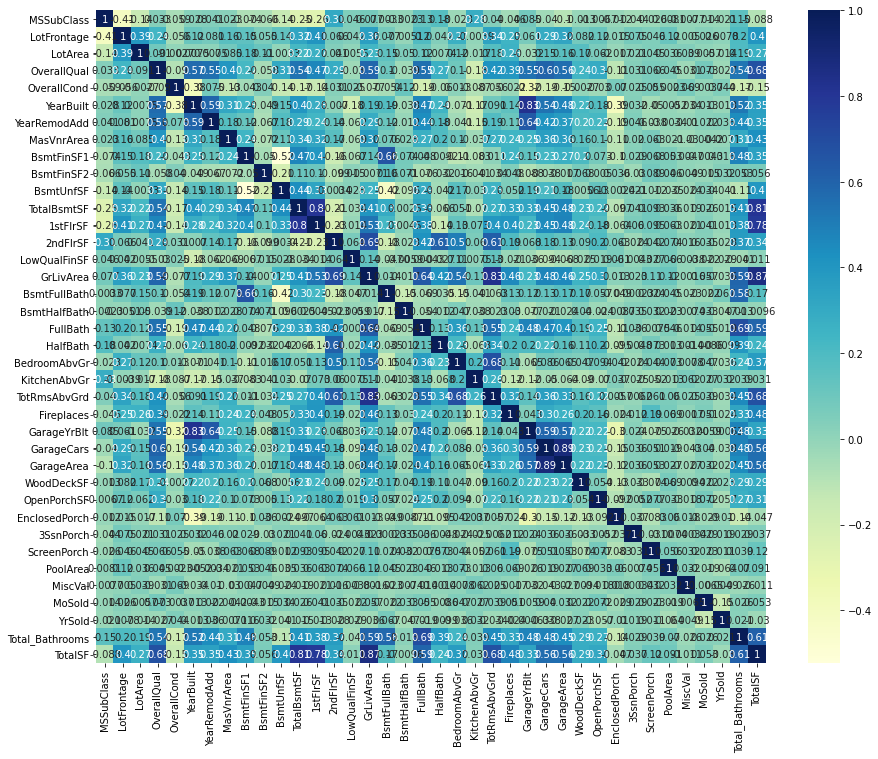

In [18]:
# heatmap
corr_X = X.corr()
f, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(corr_X, annot = True, vmax = 1, cmap="YlGnBu")

These pairs of variables showed high correlations and could cause multicollinearity. Let's drop one variable from each pair. I choose to drop the variables with lower correlation with the 'SalePrice' in each pair. Also, I dropped the redundant variables from the above analysis of the basement and bathrooms.

['GarageYrBlt', 'YearBuilt'] -> drop 'GarageYrBlt'

['GarageQual', 'GarageCond'] -> drop 'GarageCond'

['GarageCars', 'GarageArea'] -> drop 'GarageCars'

['1stFlrSF', 'TotalBsmtSF'] -> drop 'TotalBsmtSF'

['TotRmsAbvGrd', 'GrLivArea'] -> drop 'TotRmsAbvGrd'

['TotalSF', 'GrLivArea] -> drop 'GrLivArea




In [19]:
drop_cols = ['GarageYrBlt', 'GarageCond', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'BsmtFinSF2', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', '1stFlrSF', '2ndFlrSF', 'GrLivArea']
X = X.drop(drop_cols, axis = 1)
test = test.drop(drop_cols, axis = 1)

**Categorical features**

The columns of 'MSSubClass', 'YrSold', 'MoSold', 'GarageYrBlt', and 'YearBuilt' are numeric. It means the variables are assumed to carry certain values such as the year of 2007 would carry different values than the year of 2015, which impact may not be too noticeable in this prorject. Therefore, we convert these columns to categories for the better presentation. We will also encode these categorical columns with one-hot-encoder in the later section.

In [20]:
str_convert = ['MSSubClass', 'YrSold', 'MoSold', 'YearBuilt']
X[str_convert] = X[str_convert].astype(str)
test[str_convert] = test[str_convert].astype(str)

The heatmap showed that correlations are within the range of (-0.8, 0.8).

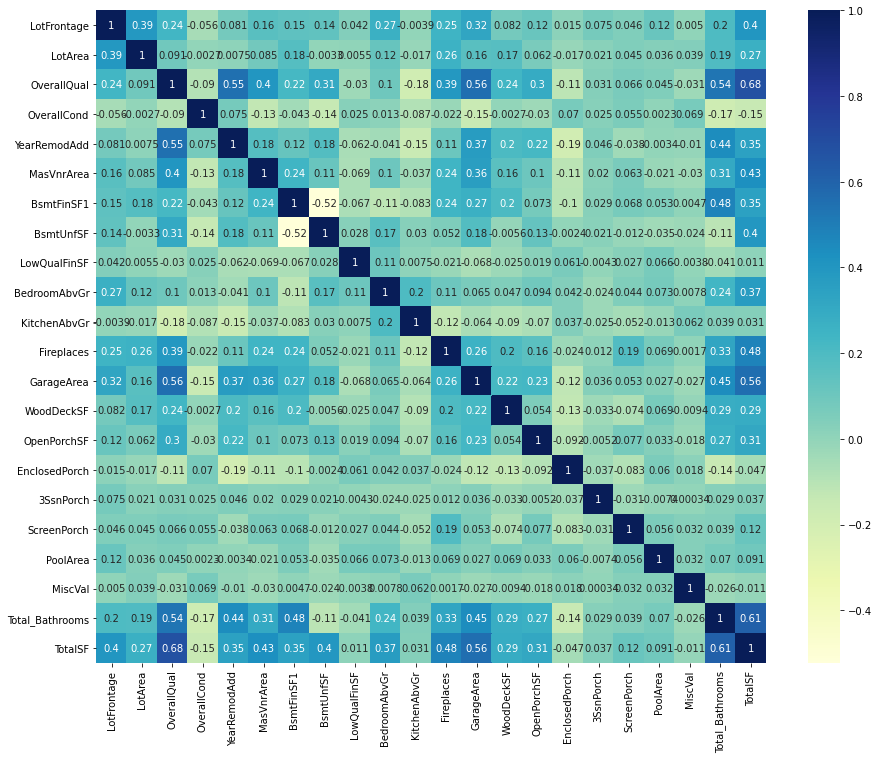

In [21]:
# heatmap
corr_X = X.corr()
f, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(corr_X, annot = True, vmax = 1, cmap="YlGnBu")

## **4, Feature Engineering**

**Imputation**

We come to the fun part of this project: imputation of missing values. Imputation is an important skill in data science because SciKit does not undertand missing values. The art of imputation is to tackle the missing values by either ignore the rows or substitue the missing values with the values closest to the reality.

Text(0.5, 1.0, 'Missing Values of the Training Dataset')

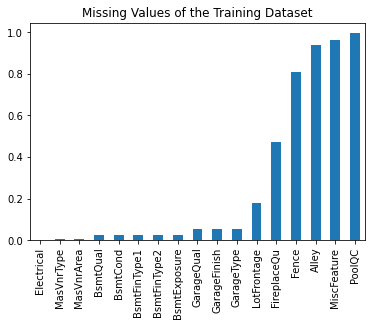

In [22]:
# let's count the missing values of the training dataset
null_train = X.isnull().mean()
null_train = null_train[null_train > 0]
null_train.sort_values(inplace = True)
ax = null_train.plot.bar()
ax.set_title('Missing Values of the Training Dataset')

Text(0.5, 1.0, 'Missing Values of the Test Dataset')

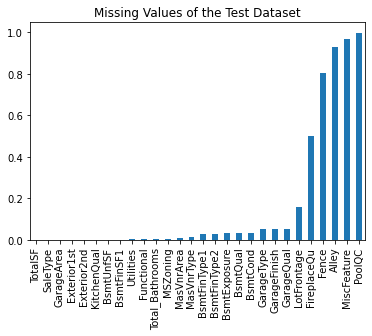

In [23]:
# let's count the missing values of the test dataset
null_test = test.isnull().mean()
null_test = null_test[null_test > 0]
null_test.sort_values(inplace = True)
ax = null_test.plot.bar()
ax.set_title('Missing Values of the Test Dataset')

The imputations for the categorical and numeric variables are consisted on differnt steps. We will walk through different imputations such as **FunctionTransformer()**, **SimpleImputer()**, and **KNNImputer()**.

Here are the steps of the imputations:

1, create **FunctionTransformer()** on most categorical and numeric variables

I presume the missing data is NOT a Missing Completely at Random, MCAR, MCAR means there is no relationship between the missingness of the data and any values, observed or missing. The reason is that the dataset was from the actual housing sales. The real estate companies have to examine the houses before listing on markets. Therefore, the missing data probably reflect the human behaviour that the real estate examiners leave it blank if he/ she didn't see the items. Let's dig into few variables for this assumption.
  - 'GarageType', 'GarageFinish', 'GarageQual' have the same 0.055556 missing values, probably these are the data from the same houses with no garage at all.
  - 'BsmtFinType2', 'BsmtExposure' have the same 0.026063, probably probably these are the data from the same houses with no basement at all.
  - 'BsmtQual', 'BsmtCond', 'BsmtFinType1' have the same 0.025377 missing values, quite close the the percentage of the above 0.026063, probably these are the data from the same houses with nobasement at all.
  - 'MasVnrType', 'MasVnrArea' have the same 0.005487 missing values, quite close the the percentage of the above 0.026063, probably these houses are the data from the same houses with no Masonry veneer at all.

This correlations between missing pairs implies that the data was left missing with intention.

2, **SimpleImputer(strategy='most_frequent')** - on 'MSZoning'
As every property must be belongs to one zoning classification, I imputed it with the mode of the columns for the best guess.

3, **KNNImputer()** - on 'LotFrontage'
I impute the missing 'LotFrontage' the mean value from n_neighbors( n = 3) nearest neighbors found in the training set. 


In [24]:
# find the categorical variables
# remove 'MSZoning' for different preprocessing later
cate_col = list(X.select_dtypes(include = 'object').columns)
cate_col_remove = ['MSZoning']
cate_col = [e for e in cate_col if e not in cate_col_remove]

# find the numerical variables
# remove 'LotFrontage' for different preprocessing later
num_col = list(X.select_dtypes(exclude = 'object').columns)
num_col_remove = ['LotFrontage']
num_col = [e for e in num_col if e not in num_col_remove]

We will apply **FunctionTransformer()** on these columns

In [25]:
print('Categorical variables:', cate_col, end = '\n')
print('Numeric variables:', num_col)

Categorical variables: ['MSSubClass', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Numeric variables: ['LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'Total_Bathrooms', 'TotalSF']


**FunctionTransformer()**

We apply FunctionTransformer() when converting the variables by the methods not covered by Scikit_learn. We can create a new function then *transform* the variable with it. Another benefit of **Function Transformer** is that you can introduce arbitrary, stateless transforms into an sklearn Pipeline in next section. This makes executing a processing pipeline easier because you can simply pass your data (X) to the fit and transform methods of the Pipeline object without having to explicitly apply each stage of the pipeline individually.

**cate_null_convertor()** - all missing values of the categorical variables would be filled by zero by fillna('missing')

**num_null_convertor()** - all missing values of the categorical variables would be filled by zero by fillna(0)

**convert_cate_null()** - the *Transformer* of the categorical variables

**convert_num_null()** - the *Transformer* of the numeric variables

These two transformer would then be included in the **pipeline()** in the later section. These two transformers can be easily replaced by **SimpleImputer()**. I used **FunctionTransformer()** for demonstrating purposes.

In [26]:
# all missing values of the categorical variables would be filled by fillna('missing')
def cate_null_convertor(df):
  df[cate_col] = df[cate_col].fillna('missing')
  return df

# all missing values of the categorical variables would be filled by zero by fillna(0)
def num_null_convertor(df):
  df[num_col] = df[num_col].fillna(0)
  return df

Convert the functions to the transformers:

In [27]:
convert_cate_null = FunctionTransformer(cate_null_convertor)
convert_num_null = FunctionTransformer(num_null_convertor)

Create the imputers



In [28]:
# if left to the default, fill_value will be 0 when imputing numerical data and 
# 'missing_value' for strings or object data types.
simple_imp= SimpleImputer() 

# replace missing using the most frequent value along each column. 
# can be used with strings or numeric data.
imp_mode = SimpleImputer(strategy='most_frequent') 

# imputed using the mean value from n_neighbors(n = 3) 
# nearest neighbors found in the training set. 
knn_imp = KNNImputer(n_neighbors = 3) # LotFrontage 

# imp_constant = SimpleImputer(strategy='constant', fill_value='missing') 

**OneHotEncoder()** 

It encodes the categorical variables using a one-hot aka one-of-K scheme. The output of **OneHotEncoder()** will be a sparse matrix where each column corresponds to one possible value of one variables. 


In [29]:
ohe = OneHotEncoder(handle_unknown='ignore') # ignore the errors

**PowerTransformer()**

It converts the data to more Gaussian-like structure. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired. I use Yeo-Johnson becausesome data are zeros. 


In [30]:
power_trans = PowerTransformer(method = 'yeo-johnson')

**StandardScaler()**

it converts data to the normal distribution with mean value 0 and standard deviation of 1. It may be more sensitive to the outliers.

In [31]:
ss = StandardScaler()

**Pipeline**

I encapsulated few imputers and the corresponding transformers in sequences through the pipelines. These pipelines would be used in next steps on different variables based on their natures. If there are no missing values in the column, the first step of the Pipeline (imputer) passes it along to the second step of the Pipeline. Of noted is that all steps except last one must be transformers, the last step can be transformer or predictor.



In [32]:
mszoning_pipe = make_pipeline(imp_mode, ohe) # 'MSZoning' - impute with mode then One=Hot-Encoder
lotfrontage_pipe = make_pipeline(knn_imp, ss) # 'LotFrontage' - impute with KNNImputer then StandardScaler

#constant_ohe_pipe = make_pipeline(imp_constant, ohe)
imp_ss_pipe = make_pipeline(simple_imp, ss) # numeric variables - impute with 0 then StandardScaler
imp_ohe_pipe = make_pipeline(simple_imp, ohe) # categorical variables - impute with 'missing_value' then One-Hot-Encoder

num_pipe = make_pipeline(convert_num_null, ss) # numeric variables - FunctionTransformer with Fillna(0) then StandardScaler
cate_pipe = make_pipeline(convert_cate_null, ohe) # categorical variables - FunctionTransformer with Fillna('missing') then One-Hot-Encoder


**ColumnTransformer()**

* First four argument (tuples) specifies that we want to the above **make_pipelines()** onto different variables. 
* 'remainder' argument specifies that we want to keep all other columns in the final output (without modifying them)


In [33]:
ct = make_column_transformer(
    (mszoning_pipe, ['MSZoning']),
    (lotfrontage_pipe, ['LotFrontage']),
    (cate_pipe, cate_col),
    (num_pipe, num_col),
    remainder = 'passthrough')

## **5, Model Building**
**Create the individual models**

We will be blending few algorithms for the StackingRegressor() and VotingRegressor() in the last section. To optimize the results for the StackingRegressor() and VotingRegressor(), I will use the diverse regressors with different natures.


In [34]:
rfr = RandomForestRegressor(random_state = 42)
gbr = GradientBoostingRegressor()
knr = KNeighborsRegressor()
sgd = SGDRegressor()
xgb = xgboost.XGBRFRegressor()
lin = LinearRegression()
eln = ElasticNet()
dtr = DecisionTreeRegressor()
las = Lasso()
svr = SVR()
pca = PCA()
rid = Ridge()

**Pipeline**

Use Pipeline to chain the sequential steps together:

1, data preprocessing using **ColumnTransformer()**

2, model building using above regressors

In [35]:
pipe_rfr = make_pipeline(ct, rfr)
pipe_knr = make_pipeline(ct, knr)
pipe_sgd = make_pipeline(ct, sgd)
pipe_gbr = make_pipeline(ct, gbr)
pipe_xgb = make_pipeline(ct, xgb)
pipe_lin = make_pipeline(ct, lin)
pipe_eln = make_pipeline(ct, eln)
pipe_dtr = make_pipeline(ct, dtr)
pipe_las = make_pipeline(ct, las)
pipe_svr = make_pipeline(ct, svr)
pipe_pca = make_pipeline(ct, pca)
pipe_rid = make_pipeline(ct, rid)

**How does cross-validation prevent data leakage?**
* cross_val_score split the data before each data transformations
* cross_val_score' does the dataset splitting, training, predictions, and evaluation
* cross_val_score transform the data after the data splits
* it allows the validation part to use the estimators 'learn' from the other four training partitions. Otherwise, it would result in data leakage

To run a villina cross-validation of each algorithms before the hyperparameter tunings. we will use the negative root mean squared error as the scoring metrics.

In [36]:
# create array of the regressors
clf_array = [lin, rfr, svr, dtr, knr, eln, rid]
clf_names = ['Linear', 'RanFor', 'SVR', 'DTR', 'KNN', 'ELN', 'RID']

mean_results = {}
results = []
labels = []

# choose the scoring
scoring = 'neg_mean_absolute_error'
m = float('-inf')

for clf, label in zip(clf_array, clf_names):
  pipe = make_pipeline(ct, clf)
  cross_val_res = cross_val_score(pipe, X, y, cv = 5, scoring = scoring)
  print('Model: ', label, '\tMean: ', cross_val_res.mean(), '\tStd ', cross_val_res.std())
  results.append(cross_val_res)
  labels.append(label)
  mean_results[label] = cross_val_res.mean()
 

print('\nBest model: ', '\t' + max(mean_results, key = mean_results.get))

Model:  Linear 	Mean:  -19411.590576040307 	Std  1685.4744147167291
Model:  RanFor 	Mean:  -16766.438226451064 	Std  743.669731590532
Model:  SVR 	Mean:  -55569.76998174747 	Std  3343.9168445324526
Model:  DTR 	Mean:  -25041.735552888007 	Std  2229.9406930414907
Model:  KNN 	Mean:  -21396.9747733371 	Std  2004.1637708028811
Model:  ELN 	Mean:  -18672.65239027342 	Std  1156.6614891774761
Model:  RID 	Mean:  -17835.346723622013 	Std  1377.7518146058453

Best model:  	RanFor


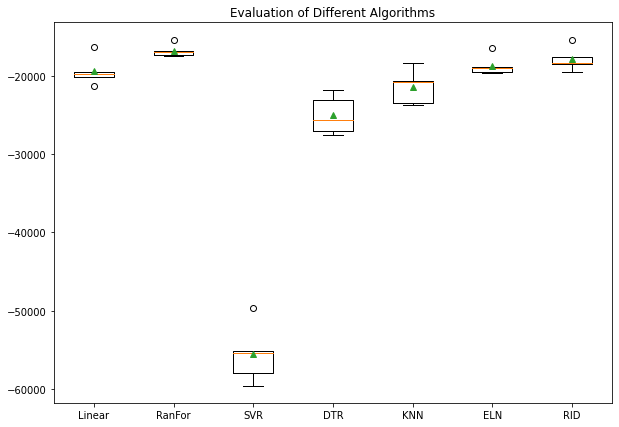

In [37]:
plt.figure(figsize=(10, 7))
plt.title('Evaluation of Different Algorithms')
plt.boxplot(results, labels=labels, showmeans=True)
plt.show()

The graph shows that RandomForestRegressor yields that best root mean absolute error and small variance. We will do the hyperparameter tuning on the Random Forest Regressor. 

In [38]:
pipe_rfr.fit(X, y);

In [39]:
y_pred_rfr = pipe_rfr.predict(test)

In [40]:
submission_rfr = pd.DataFrame({'Id' : test_id, 'SalePrice' : y_pred_rfr})
submission_rfr.head(10)

,Id,SalePrice
0,1461,125217.71
1,1462,172379.10
2,1463,178676.42
3,1464,183118.81
4,1465,194743.86
5,1466,179205.00
6,1467,176471.93
7,1468,176225.30
8,1469,190418.04
9,1470,129995.82


In [41]:
# submission_rfr.to_csv('Submission_rfr.csv', index=False) 
# files.download('Submission_rfr.csv')

**Public score of Random Forest without hyperparameter tuning: 0.14751** 

It is the baseline.

In [42]:
# !kaggle competitions submit -c house-prices-advanced-regression-techniques -f Submission_rfr.csv -m "Message"

**Hyperparameters Tuning** 

* Hyperparameters are values you set, whereas "parameters" are values learned by the estimator during the fitting process

* Hyperparameter tuning is likely to result in a more accurate model

How to set the hyperparameters? 

1, Create an empty dictionary called params

2, Choosing which hyperparameters to tune and what values to try requires both research and experience
  * The dictionary key is the step name, followed by 2 underscores, followed by the hyperparameter name
  * The dictionary value is the list of values you want to try for that hyperparameter
For our random forest regression model, we will tune:
* n_estimators - the number of trees
* max_depth - the longest path between the root node and the leaf node
  



In [43]:
params_rfr = {}
params_rfr['randomforestregressor__n_estimators'] = [int(i) for i in range(100, 500, 100)]
#params_rfr['randomforestregressor__max_features'] = ['auto', 'sqrt']
params_rfr['randomforestregressor__max_depth'] = [int(i) for i in range(10, 100, 20)]
#params_rfr['randomforestregressor__min_samples_split'] = [int(i) for i in range(1, 10, 2)]

**RandomizedSearchCV**

In contrast to GridSearchCV, RandomizedSearchCV does not try out all parameter values but rather a fixed number of parameter settings is sampled from the specified distributions. Though it takes much limited numbers of seachings, its returning results are close enough to GridSearchCV and sometimes even outperform the GridSearchCV.

* Creating a RandomizedSearchCV instance is similar to cross_val_score, except that you don't pass X and y but you do pass params
* Fitting the RandomizedSearchCV object performs the random search



In [44]:
rand_rfr = RandomizedSearchCV(pipe_rfr, params_rfr, cv = 5, scoring = scoring)
rand_rfr.fit(X, y);
#best_model_gbr = rand_gbr.best_estimator_

In [45]:
# show the best estimators of the RandomizedSearchCV
best_estimator_rfr = rand_rfr.best_estimator_
best_estimator_rfr.steps[-1][1]

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [46]:
# print out the results
print(f'Root mean absolute error for the best model of random forest regressor: \n {-rand_rfr.best_score_} \n')


Root mean absolute error for the best model of random forest regressor: 
 16699.491510780023 



In [47]:
y_pred_rand_rfr = rand_rfr.predict(test)

In [48]:
submission_rand_rfr = pd.DataFrame({'Id' : test_id, 'SalePrice' : y_pred_rand_rfr})
submission_rand_rfr.head(10)

,Id,SalePrice
0,1461,127363.9600
1,1462,169711.4300
2,1463,178076.1325
3,1464,184218.3025
4,1465,193465.4775
5,1466,180299.3250
6,1467,176794.0750
7,1468,176090.1350
8,1469,189468.9975
9,1470,130037.6825


In [49]:
# submission_rand_rfr.to_csv('Submission_rand_rfr.csv', index=False) 
# files.download('Submission_rand_rfr.csv')

In [50]:
# !kaggle competitions submit -c house-prices-advanced-regression-techniques -f Submission_rand_rfr.csv -m "Message"

**Public score of Random Forest with hyperparameter-tuning: 0.14693**

There is a small improvement. 

## **Stacking Regressor**

Stacking is an blending learning technique to combine multiple regression models via a meta-regressor. Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [51]:
estimators = [('Linear', pipe_lin),
              ('Elastic Net', pipe_eln),
              ('Ridge', pipe_rid)]

stacking_regressor = StackingRegressor(
    estimators = estimators, final_estimator = RandomForestRegressor(max_depth=70, n_estimators=400))
stacking_regressor

StackingRegressor(cv=None,
                  estimators=[('Linear',
                               Pipeline(memory=None,
                                        steps=[('columntransformer',
                                                ColumnTransformer(n_jobs=None,
                                                                  remainder='passthrough',
                                                                  sparse_threshold=0.3,
                                                                  transformer_weights=None,
                                                                  transformers=[('pipeline-1',
                                                                                 Pipeline(memory=None,
                                                                                          steps=[('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=False,
              

In [52]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

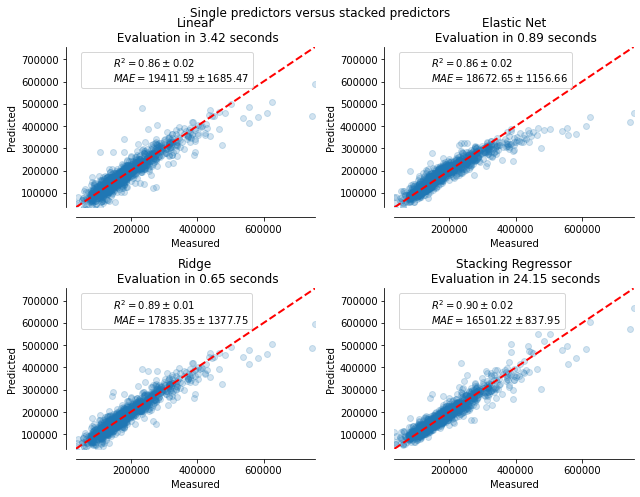

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)
    
plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The graph showed that the stacking Regressor made a slight improvement on the model. 

In [54]:
stacking_score = cross_val_score(stacking_regressor, X, y, cv = 5, scoring = scoring)

In [55]:
# print out the results
print(f'Root mean absolute error of the stacking method:', -(stacking_score.mean()))

Root mean absolute error of the stacking method: 16492.088924651653


In [56]:
stacking_regressor.fit(X, y);

In [57]:
y_pred_stacking = stacking_regressor.predict(test)

In [58]:
submission_stacking = pd.DataFrame({'Id' : test_id, 'SalePrice' : y_pred_stacking})
submission_stacking.head(10)

,Id,SalePrice
0,1461,116956.2175
1,1462,151551.0000
2,1463,178826.6575
3,1464,184743.0975
4,1465,193959.6000
5,1466,164971.9550
6,1467,167806.0500
7,1468,155244.0000
8,1469,194374.4625
9,1470,116090.9500


In [59]:
# submission_stacking.to_csv('Submission_stacking.csv', index=False) 
# files.download('Submission_stacking.csv')

In [60]:
# !kaggle competitions submit -c house-prices-advanced-regression-techniques -f Submission_stacking.csv -m "Message"

**Public score of VotingRegressor: 0.14400**

There is a small improvement.

## **Voting Regressor**

The voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. It uses several estimators and returns the final result as the average of predicted values.

In [61]:
estimators = [('Linear', pipe_lin),
              ('Elastic Net', pipe_eln),
              ('Ridge', pipe_rid),
              ('RandomF', pipe_rfr),
              ('SVR', pipe_svr),
              ('Decision Tree', pipe_dtr)]

voting = VotingRegressor(estimators = estimators)

In [62]:
voting_score = cross_val_score(voting, X, y, cv = 5, scoring = scoring)

In [63]:
# print out the results
print(f'Root mean absolute error of the voting method:', -(voting_score.mean()))

Root mean absolute error of the voting method: 17724.110829189853


In [64]:
voting.fit(X, y);

In [65]:
y_pred_voting = voting.predict(test)

In [66]:
submission_voting = pd.DataFrame({'Id' : test_id, 'SalePrice' : y_pred_voting})
submission_voting.head(10)

,Id,SalePrice
0,1461,124932.659230
1,1462,166312.714483
2,1463,183351.110382
3,1464,187905.146985
4,1465,193835.328026
5,1466,169462.652329
6,1467,174240.771595
7,1468,166105.001361
8,1469,192289.223509
9,1470,124347.715223


In [67]:
# submission_voting.to_csv('Submission_voting.csv', index=False) 
# files.download('Submission_voting.csv')

In [68]:
# !kaggle competitions submit -c house-prices-advanced-regression-techniques -f Submission_voting.csv -m "Message"

**Public score of the Voting Regressor: 0.14400**

## **Conclusion**

In this project, I have used Random Forest Regressor with hyperparameter tuning, stacking regressor, and voting regressor. The public scores obtained from all models are around 0.14. 

One improvement I can think of is to increase the diversity of the algorithms.By choosing a different algorithm. Certain algorithms capitalize on different relationships within the data. For example, a linear model will focus on a linear relationship, a non-linear model can capture better a non-linear relationships. So predictions may come a bit different